In [1]:
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns
import os
from scipy.spatial import distance
from scripts.vectology_functions import create_aaa_distances

Set up some things

In [2]:
os.makedirs('output', exist_ok=True)

Get some variable data

In [13]:
#original data from Vectology abstract
demoData=[
    "Crohn's disease",
    "Breast cancer",
    "Prostate cancer",
    "Systolic blood pressure",
    "Coronary heart disease",
    "Inflammatory bowel disease",
    "Impedance of whole body",
    "Body mass index",
    'Atorvastatin',
    'Fluvastatin',
    'Ezetimibe',
    'Gemfibrozil',
    'Tamoxifen',
    'Docetaxel',
    "Ulcerative colitis",
    'Weight change compared with 1 year ago',
    "LDL cholesterol",
]
demo_df=pd.DataFrame(demoData)
print(demo_df.head())

                         0
0          Crohn's disease
1            Breast cancer
2          Prostate cancer
3  Systolic blood pressure
4   Coronary heart disease


Create vectors for each variable

In [4]:
vectology_api_url='http://vectology-api.mrcieu.ac.uk'

encode_url=vectology_api_url+'/encode'

vectorDic={}

#loop through 10 rows at a time
for k,g in demo_df.groupby(np.arange(len(demo_df))//10):
    textList=list(g['processed'].values)
    params = {
        "text_list":textList,
        "model_name":"BioSentVec",
        }
    response = requests.post(encode_url, data=json.dumps(params))
    res = response.json()
    #print(k,len(res['embeddings']))
    
    #add to dictionary
    for i in range(0,len(textList)):
        #ignore empty vectors
        if np.count_nonzero(res['embeddings'][i])>0:
            vectorDic[textList[i]]=res['embeddings'][i]

print(len(vectorDic),'vectors created')        

17 vectors created


Compare all against all using cosine

In [17]:
# create 2d matrix of vectors
vector_2d = list(vectorDic.values())

# do all against all cosine
vector_matrix = create_aaa_distances(vector_2d)

Creating distances...
17
136


In [26]:
# create term-score-term triples
def create_triples(vector_matrix, term_list):
    d = []
    mCount=0
    for i in range(0,len(term_list)):
        for j in range(i,len(term_list)):
            if i != j:
                #print(ids[i],ids[j],1-pws[mCount])
                score = 1-vector_matrix[mCount]
                d.append({'source':term_list[i],'score':score,'target':term_list[j]})
                mCount+=1
    df = pd.DataFrame(d)
    print(df.head())
    return df

create_triples(vector_matrix,demoData)

            source     score                      target
0  Crohn's disease  0.172876               Breast cancer
1  Crohn's disease  0.177908             Prostate cancer
2  Crohn's disease  0.066329     Systolic blood pressure
3  Crohn's disease  0.208874      Coronary heart disease
4  Crohn's disease  0.503975  Inflammatory bowel disease


,source,score,target
0,Crohn's disease,0.172876,Breast cancer
1,Crohn's disease,0.177908,Prostate cancer
2,Crohn's disease,0.066329,Systolic blood pressure
3,Crohn's disease,0.208874,Coronary heart disease
4,Crohn's disease,0.503975,Inflammatory bowel disease
...,...,...,...
131,Docetaxel,0.089202,Weight change compared with 1 year ago
132,Docetaxel,0.117714,LDL cholesterol
133,Ulcerative colitis,0.150756,Weight change compared with 1 year ago
134,Ulcerative colitis,0.248524,LDL cholesterol


Visualise

In [31]:
def plot_compare(dis,name,term_list):
    dis_dic={}
    mCount=0
    for i in range(0,len(term_list)):
        dis_dic[term_list[i]]={}
    for i in range(0,len(term_list)):
        for j in range(i,len(term_list)):
            if i != j:
                score = 1-dis[mCount]
                mCount+=1
                dis_dic[term_list[i]][term_list[j]]=score
                dis_dic[term_list[j]][term_list[i]]=score
    df = pd.DataFrame(dis_dic)
    #sort the rows and columns to be in same order and replace diagonal
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.sort_index()
    #print(df.head())
    #replace NaN with 1 to create perfect maps on the diagonal
    df = df.fillna(1)
    
    sns_plot = sns.clustermap(
        df,
        cmap='coolwarm',
    )
    #sns_plot.ax_heatmap.set_title(name)
    sns_plot.savefig(f"output/{name}.pdf",dpi=1000)
    return df


,Atorvastatin,Body mass index,Breast cancer,Coronary heart disease,Crohn's disease,Docetaxel,Ezetimibe,Fluvastatin,Gemfibrozil,Impedance of whole body,Inflammatory bowel disease,LDL cholesterol,Prostate cancer,Systolic blood pressure,Tamoxifen,Ulcerative colitis,Weight change compared with 1 year ago
Atorvastatin,1.000000,0.080269,0.091339,0.289199,0.058361,0.248632,0.546541,0.615873,0.482490,0.055053,0.081951,0.401499,0.108604,0.216838,0.277861,0.078211,0.104267
Body mass index,0.080269,1.000000,0.175985,0.281758,0.160145,0.091991,0.067325,0.124320,0.088222,0.221003,0.225314,0.260931,0.131360,0.312062,0.080142,0.193561,0.303251
Breast cancer,0.091339,0.175985,1.000000,0.324492,0.172876,0.254492,0.049106,0.115004,0.129686,0.108945,0.242969,0.178051,0.562693,0.111751,0.398672,0.187865,0.142661
Coronary heart disease,0.289199,0.281758,0.324492,1.000000,0.208874,0.086973,0.241864,0.299472,0.309010,0.088919,0.264127,0.452671,0.275416,0.369106,0.161925,0.273522,0.168166
Crohn's disease,0.058361,0.160145,0.172876,0.208874,1.000000,0.062134,0.133584,0.088268,0.035872,0.123466,0.503975,0.157908,0.177908,0.066329,0.063103,0.513348,0.156980
Docetaxel,0.248632,0.091991,0.254492,0.086973,0.062134,1.000000,0.245276,0.265095,0.215983,0.042966,0.096383,0.117714,0.324769,0.050752,0.329511,0.114503,0.089202
Ezetimibe,0.546541,0.067325,0.049106,0.241864,0.133584,0.245276,1.000000,0.508934,0.505387,0.007546,0.215374,0.521182,0.101850,0.142301,0.252621,0.182157,0.105282
Fluvastatin,0.615873,0.124320,0.115004,0.299472,0.088268,0.265095,0.508934,1.000000,0.534310,0.010649,0.163240,0.405786,0.111963,0.163317,0.303272,0.167121,0.090218
Gemfibrozil,0.482490,0.088222,0.129686,0.309010,0.035872,0.215983,0.505387,0.534310,1.000000,0.019592,0.105992,0.439448,0.100802,0.169406,0.308209,0.107585,0.118355
Impedance of whole body,0.055053,0.221003,0.108945,0.088919,0.123466,0.042966,0.007546,0.010649,0.019592,1.000000,0.088489,0.089933,0.093581,0.142345,0.052506,0.073403,0.167201


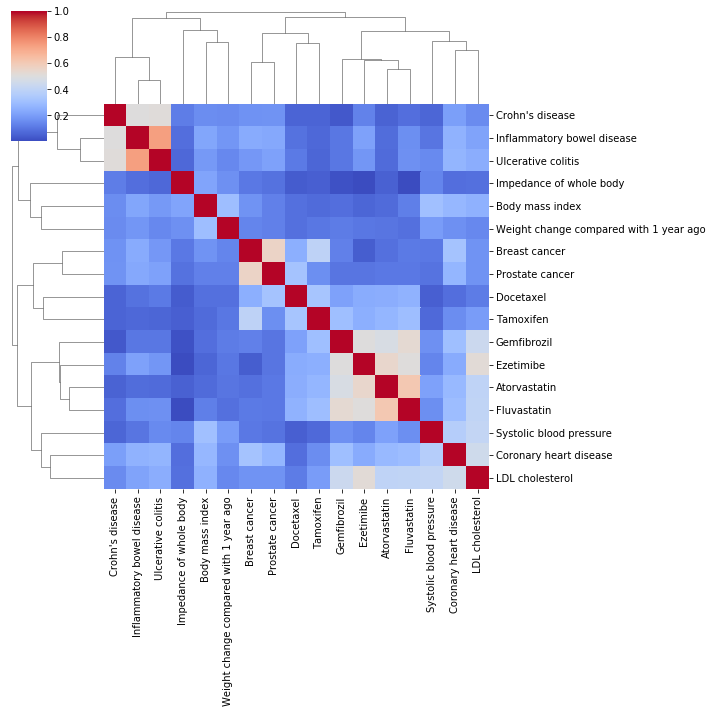

In [32]:
plot_compare(vector_matrix,'test',demoData)